In [1]:
import sys
import os
import mne
# Aller chercher le dossier racine en remontant depuis notebooks/
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.preprocessing.windowing import extract_epochs_from_annotations



# Configuration
subject = 1
runs = [6, 10, 14]
output_dir = "../../data/processed/"
os.makedirs(output_dir, exist_ok=True)


In [2]:
# Charger les fichiers EDF pour un sujet donné (runs 6, 10, 14)
files = mne.datasets.eegbci.load_data(subjects=[subject], runs=runs)
# 📥 Lire tous les fichiers EDF, preload obligatoire
raws = [mne.io.read_raw_edf(f, preload=True) for f in files]

# 🔗 Concaténer les fichiers en un seul objet Raw
raw = mne.concatenate_raws(raws)

# ❌ Supprimer les canaux conflictuels *sur raw*, pas raws
raw.drop_channels(["CZ", "FCZ", "CPZ"], on_missing="ignore")

# 🧠 Appliquer le montage standard (nécessaire pour les topomaps)
montage = mne.channels.make_standard_montage("standard_1020")
raw.rename_channels(lambda name: name.strip(".").upper())
raw.set_montage(montage, on_missing="ignore")

# 🔎 Vérification
raw.info




Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCZ, FC2, FC4, FC6, C5, C3, C1, CZ, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 55 items (3 Cardinal, 52 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

In [3]:
raw.filter(1., 40., fir_design='firwin')
raw.notch_filter(freqs=50.0)


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MiB, data loaded>

In [4]:
raw.set_eeg_reference('average', projection=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MiB, data loaded>

In [5]:
import numpy as np

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter='auto')
ica.fit(raw.copy().crop(tmax=60.0))

sources = ica.get_sources(raw.copy().crop(tmax=60.0)).get_data()
variances = np.var(sources, axis=1)
ica.exclude = np.argsort(variances)[-4:].tolist()

print(f"🔎 Composantes exclues automatiquement : {ica.exclude}")

# (facultatif) Visualisation de la projection sur le signal
ica.plot_sources(raw.copy().crop(tmax=60.0))

# Application sur tout le signal
raw_clean = ica.apply(raw.copy())


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.3s.
🔎 Composantes exclues automatiquement : [16, 12, 19, 3]
Creating RawArray with float64 data, n_channels=20, n_times=9601
    Range : 0 ... 9600 =      0.000 ...    60.000 secs
Ready.
Using qt as 2D backend.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


In [6]:
# Affichage du signal original (brut)
raw.plot(n_channels=20, title="🔴 Signal EEG brut (avant ICA)", duration=10, start=0)

# Affichage du signal nettoyé par ICA
raw_clean.plot(n_channels=20, title="🟢 Signal EEG nettoyé (après ICA)", duration=10, start=0)


In [7]:
X, y = extract_epochs_from_annotations(raw_clean, 0.0, 4.0)


✅ Extraction des événements depuis les annotations...
✅ 90 événements détectés : {np.str_('T0'): 2, np.str_('T1'): 3, np.str_('T2'): 4}
🔢 Extraction des données numpy : (90, 64, 641) — Labels : [2 3 4]


In [8]:
# Affichage sécurisé
import numpy as np
np.unique(y, return_counts=True)


(array([2, 3, 4]), array([45, 21, 24]))

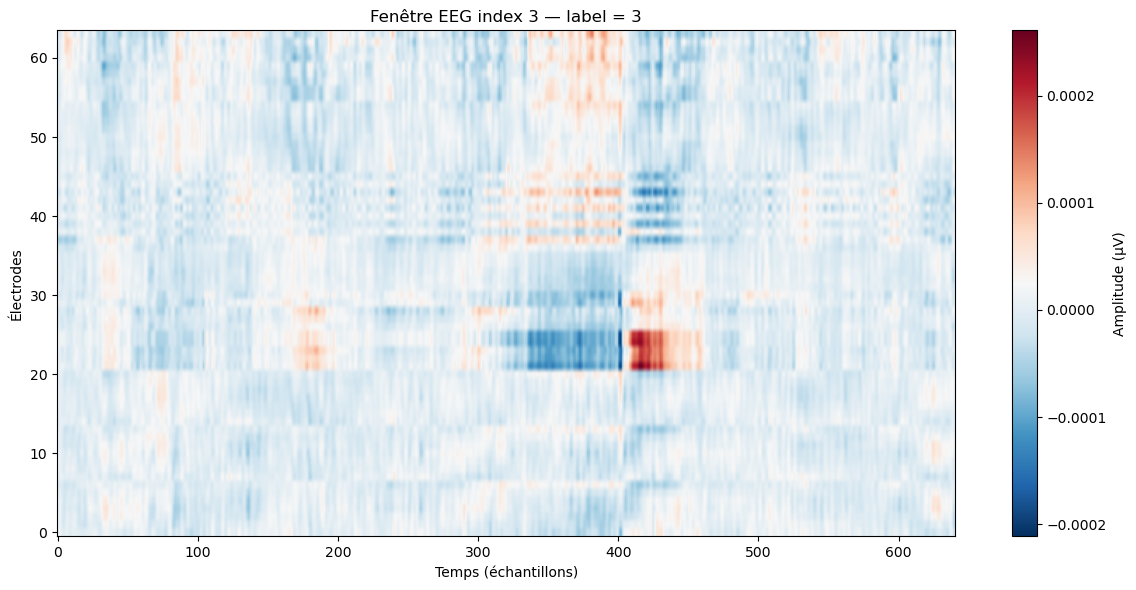

In [9]:
import matplotlib.pyplot as plt

# Choix d’un index à afficher (entre 0 et len(X)-1)
i = 3

# Affichage
plt.figure(figsize=(12, 6))
plt.imshow(X[i], aspect='auto', cmap='RdBu_r', origin='lower')
plt.colorbar(label="Amplitude (µV)")
plt.xlabel("Temps (échantillons)")
plt.ylabel("Électrodes")
plt.title(f"Fenêtre EEG index {i} — label = {y[i]}")
plt.tight_layout()
plt.show()


In [10]:
print(f"Amplitude min : {X[i].min():.2e}")
print(f"Amplitude max : {X[i].max():.2e}")
print(f"Écart-type moyen par canal : {X[i].std(axis=1).mean():.2e}")


Amplitude min : -2.11e-04
Amplitude max : 2.61e-04
Écart-type moyen par canal : 2.53e-05


In [11]:
from ipywidgets import interact

def plot_window(i=0, gain=1e5, offset=10):
    X_centered = X[i] - X[i].mean(axis=1, keepdims=True)
    plt.figure(figsize=(12, 6))
    for ch in range(X_centered.shape[0]):
        plt.plot(gain * X_centered[ch] + ch * offset, linewidth=0.8)
    plt.title(f"Fenêtre EEG #{i} — label {y[i]}")
    plt.xlabel("Temps (échantillons)")
    plt.ylabel("Amplitude relative")
    plt.yticks([])
    plt.tight_layout()
    plt.show()

interact(plot_window, i=(0, len(X)-1), gain=(1e4, 2e5, 1e4), offset=(5, 20, 1))


interactive(children=(IntSlider(value=0, description='i', max=89), FloatSlider(value=100000.0, description='ga…

<function __main__.plot_window(i=0, gain=100000.0, offset=10)>

In [12]:
output_path = os.path.join(output_dir, f"subject_{subject}_cleaned_raw.fif")
raw_clean.save(output_path, overwrite=True)
print(f"💾 Signal pré-traité sauvegardé dans : {output_path}")


Overwriting existing file.
Writing C:\Users\Antoi\Documents\EEG-BCI\notebooks\..\..\data\processed\subject_1_cleaned_raw.fif
Closing C:\Users\Antoi\Documents\EEG-BCI\notebooks\..\..\data\processed\subject_1_cleaned_raw.fif
[done]
💾 Signal pré-traité sauvegardé dans : ../../data/processed/subject_1_cleaned_raw.fif


In [13]:
np.save("X_windows.npy", X)  # ou X_windows selon ton code
np.save("y_windows.npy", y)
